### Model-Agnostic Meta-Learning for Fast Adaptation

- The metalearning approach of both Reptile and MAML is to come up with an **initialization** for neural networks that is *easily generalizable to similar tasks*. This is different to “Learning to Learn by Gradient Descent by Gradient Descent” in which we weren’t learning an initialization but rather an optimizer.

- This approach is very similar to **transfer learning**, in which we train a network on, say, ImageNet, and it later turns out that fine-tuning this network makes it easy to learn another image dataset, with much less data. *Indeed, transfer learning can be seen as a form of metalearning*.
- The difference here is that the metalearning initial network was trained with the **explicit purpose of being easily generalizable**, whereas transfer learning just “accidentally” happens to work, and thus might not work optimally.
- Indeed, it is fairly easy to find a in which transfer learnings fails to learn a good initialization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random
import seaborn as sbs
from tqdm import tqdm_notebook as tqdm
sbs.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Sine Wave Regression

- $ y= a \sin (x+b)$, where $a,b \sim \mathit{U}$
- In this K-shot problem, each task consists in learning a modified sine function. Specifically, for each task, the underlying function will be of the form $y= a \sin (x+b)$, with both a and b chosen randomly, and the goal of our neural network is to learn to find y given x based on only 10 (x, y) pairs.
- 10-shot learning. Each task has a different a and b. We'd like to find a common initial weight which can be a good starting point for multiple tasks. 

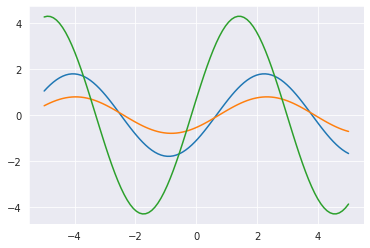

In [2]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

- To understand why this is going to be a problem for transfer learning, let's plot 1,000 of them:

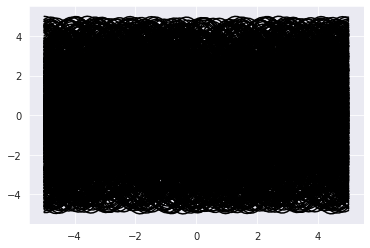

In [3]:
for _ in range(1000):
    SineWaveTask().plot(color='black')

- Since there are multiple possible values for each x across multiple tasks, if we train a single neural net to deal with multiple tasks at the same time, its best bet will simply be to return the average y value across all tasks.

In [4]:
TRAIN_SIZE = 10000
TEST_SIZE = 1000

class ModifiableModule(nn.Module):
    def params(self):
        return [p for _, p in self.named_params()]
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self):
        subparams = []
        for name, mod in self.named_submodules():
            for subname, param in mod.named_params():
                subparams.append((name + '.' + subname, param))
        return self.named_leaves() + subparams
    
    def set_param(self, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in self.named_submodules():
                if module_name == name:
                    mod.set_param(rest, param)
                    break
        else:
            setattr(self, name, param)
            
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = V(param.data.clone(), requires_grad=True)
            self.set_param(name, param)

class GradLinear(ModifiableModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
        self.weights = V(ignore.weight.data, requires_grad=True)
        self.bias = V(ignore.bias.data, requires_grad=True)
        
    def forward(self, x):
        return F.linear(x, self.weights, self.bias)
    
    def named_leaves(self):
        return [('weights', self.weights), ('bias', self.bias)]

In [5]:
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

- $X \sim \mathit{U(-5,5)}$, we do while loop below until we have all negative or all positive Xs

In [6]:
ONE_SIDED_EXAMPLE = None
while ONE_SIDED_EXAMPLE is None:
    cur = SineWaveTask()
    x, _ = cur.training_set()
    x = x.numpy()
    if np.max(x) < 0 or np.min(x) > 0:
        ONE_SIDED_EXAMPLE = cur

In [7]:
ONE_SIDED_EXAMPLE.train_x

array([0.1229355 , 1.32294738, 4.20369071, 0.54911591, 2.01476486,
       3.9954437 , 2.90224462, 2.90734896, 0.32507379, 1.30539771])

In [8]:
class SineModel(ModifiableModule):
    def __init__(self):
        super().__init__()
        self.hidden1 = GradLinear(1, 40)
        self.hidden2 = GradLinear(40, 40)
        self.out = GradLinear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

In [9]:
SINE_TRANSFER = SineModel()

- **sine_fit1 method**:
    - a **single update** function. optim에 인자를 전달하면 optim.update까지 하고, optim=None이면 loss.backward만해서 gradient만 계산한 상태로 끝나는 함수

In [10]:
def sine_fit1(net, wave, optim=None, get_test_loss=False, create_graph=False, force_new=False):
    net.train()
    if optim is not None:
        optim.zero_grad()
    x, y = wave.training_set(force_new=force_new)
    loss = F.mse_loss(net(V(x[:, None])), V(y).unsqueeze(1))
    loss.backward(create_graph=create_graph, retain_graph=True)
    # optim을 넣어야 optim.step() 하고, 안 넣으면 loss.backward만해서 
    # params에 gradient가 주렁 달려있는 상황
    
    if optim is not None:      
        optim.step()
    if get_test_loss:
        net.eval()
        x, y = wave.test_set()
        loss_test = F.mse_loss(net(V(x[:, None])), V(y))
        return loss.data.cpu().numpy()[0], loss_test.data.cpu().numpy()[0]
    return loss.data.cpu().numpy()#[0]

def fit_transfer(epochs=1):
    optim = torch.optim.Adam(SINE_TRANSFER.params())

    for _ in range(epochs):
        for t in random.sample(SINE_TRAIN, len(SINE_TRAIN)):
            sine_fit1(SINE_TRANSFER, t, optim)

In [11]:
fit_transfer()

- I think this is not exactly a 'transfer learning'. This is a single network trained on multiple tasks.

In [12]:
def copy_sine_model(model):
    m = SineModel()
    m.copy(model)
    return m

def eval_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    model = copy_sine_model(model)
    # Not sure if this should be Adam or SGD.
    optim = torch.optim.SGD(model.params(), lr)
        
    def get_loss(res):
        return F.mse_loss(res, V(ytest[:, None])).cpu().data.numpy()#[0]
    
    fit_res = []
    if 0 in fits:
        results = model(V(xtest[:, None]))
        fit_res.append((0, results, get_loss(results)))
    for i in range(np.max(fits)):
        sine_fit1(model, test, optim)
        if i + 1 in fits:
            results = model(V(xtest[:, None]))
            fit_res.append(
                (
                    i + 1, 
                    results,
                    get_loss(results)
                )
            )

    return fit_res

def plot_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    fit_res = eval_sine_test(model, test, fits, lr)
    
    train, = plt.plot(xtrain.numpy(), ytrain.numpy(), '^')
    ground_truth, = plt.plot(xtest.numpy(), ytest.numpy())
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(xtest.numpy(), res.cpu().data.numpy()[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.show()

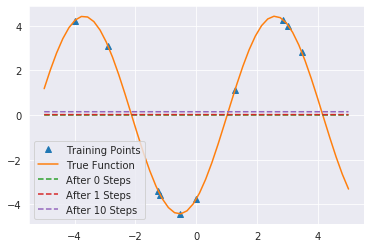

In [13]:
plot_sine_test(SINE_TRANSFER, SINE_TEST[0], fits=[0, 1, 10], lr=0.02)

- Initial points are not good, so after a sinlge gradient step update, it can't adapt to a new given task. (new sine wave)

#### MAML

- MAML runs one iteration of gradient descent and then updates the initial weights based on how much progress that one iteration made.
    - Creates a copy of the initialization weights
    - Runs an iteration of gradient descent for a random task on the copy
    - Backpropagates the loss on a test set through the iteration of gradient descent and back to the initial weights

- We thus need to take a gradient of a gradient, aka a second degree derivative in this process. Fortunately this is something that PyTorch supports now.
- Because we are going to use second derivatives, we need to make sure that the computational graph that allowed us to compute the original gradients stays around, which is why we pass create_graph=True to .backward().

- **maml_sine method**
    - $\theta_{meta}$: meta-learning
    - $\theta_{adapt}$: adaptation to tasks 
    - maml_sine takes 'model' and 'optimizer' is for updating $\theta_{meta}$
    - We run a single gradient update $\theta_{adapt} = \theta_{meta} - \alpha \times \nabla_\theta \mathcal{L}_{\mathcal{T}_i} $
    - We run another gradient update to minimize the loss of different tasks at each $\theta_{adapt, i}$

In [14]:
def maml_sine(model, epochs, lr_inner=0.01, batch_size=1, first_order=False):
    optimizer = torch.optim.Adam(model.params())
    
    for epoch in range(epochs):
        # Note: the paper doesn't specify the meta-batch size for this task,
        # so I just use 1 for now.
        for i, t in enumerate(random.sample(SINE_TRAIN, len(SINE_TRAIN))):
            new_model = SineModel()
            new_model.copy(model, same_var=True)
            loss = sine_fit1(new_model, t, create_graph=not first_order)  
            # 각 NN 모델을 training set (여러 sine wave)에 대해 single update를 수행하는데, optim=None 이므로 
            # optim.update는 안하고 loss.backward만 되어 있는 상황. second order gradient를 취하기 위해 사용한 trick
            
            for name, param in new_model.named_params():
                grad = param.grad
                if first_order:
                    grad = V(grad.detach().data)
                new_model.set_param(name, param - lr_inner * grad)
                        
            sine_fit1(new_model, t, force_new=True)        
            if (i + 1) % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
        print('epoch {} finished.'.format(epoch))

In [15]:
maml_model = SineModel() ## NN 생성

In [16]:
maml_sine(maml_model, 4)

epoch 0 finished.
epoch 1 finished.
epoch 2 finished.
epoch 3 finished.


In [17]:
def plot_sine_learning(models, fits=(0, 1), lr=0.01, marker='s', linestyle='--'):
    data = {'model': [], 'fits': [], 'loss': [], 'set': []}
    for name, models in models:
        if not isinstance(models, list):
            models = [models]
        for n_model, model in enumerate(models):
            for n_test, test in enumerate(SINE_TEST):
                n_test = n_model * len(SINE_TEST) + n_test
                fit_res = eval_sine_test(model, test, fits, lr)
                for n, _, loss in fit_res:
                    data['model'].append(name)
                    data['fits'].append(n)
                    data['loss'].append(loss)
                    data['set'].append(n_test)
        
    ax = sbs.tsplot(
        pd.DataFrame(data), condition='model', value='loss',
        time='fits', unit='set', marker=marker, linestyle=linestyle)

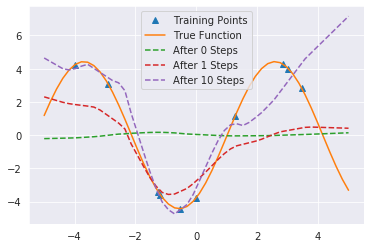

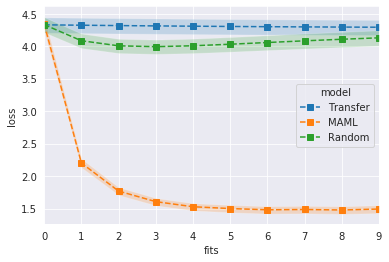

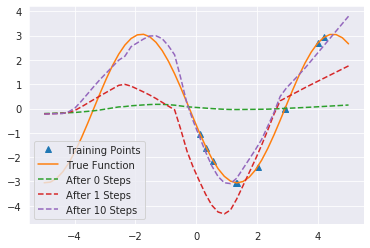

In [19]:
plot_sine_test(maml_model, SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('Transfer', SINE_TRANSFER), ('MAML', maml_model), ('Random', SineModel())],
    list(range(10)),
)
plt.show()

plot_sine_test(maml_model, ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()

- So MAML works much better than transfer learning or random initialization for this problem. 
- However, it is a bit annoying that we have to use second order derivatives for this... it forces the code to be complicated and it also makes things a fair bit slower -> we can do first-order approximation. 

-------------------------------

- "Model Agnostic Meta Learning or MAML is currently one of the best
approaches for few-shot learning via meta-learning. MAML is simple, elegant
and very powerful, however, it has a variety of issues, such as being very sensitive to neural network architectures, often leading to instability during training." (*A. Antoniou, How to train your MAML, ICLR 2019*)